In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

import os
import cv2
from os import walk
import glob as gb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
gpu_device = tf.config.experimental.list_physical_devices('GPU')
print(f"Number of GPU = {len(gpu_device)}")
tf.config.experimental.set_memory_growth(gpu_device[0], True)

Number of GPU = 1


In [3]:
SEED = 1000
IMG_SIZE = 50
BATCH_SIZE = 128
TRAIN_DIR = 'E:/Dataset/training_set'
TEST_DIR = 'E:/Dataset/test_set'

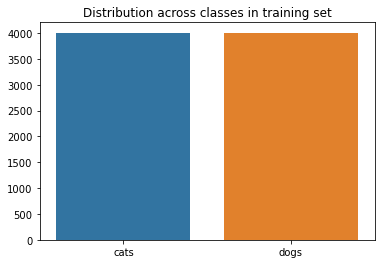

Total Train Examples = 8005


In [4]:
class_names = []
class_count = []
TRAIN_EXAMPLES = 0
for folder in  os.listdir(TRAIN_DIR) : 
    files = gb.glob(pathname= str( TRAIN_DIR + '//' + folder + '/*.jpg'))
    class_names.append(folder)
    class_count.append(len(files))
    TRAIN_EXAMPLES += len(files)
    
sns.barplot(x = class_names, y=class_count).set_title("Distribution across classes in training set")
plt.show()

print(f'Total Train Examples = {TRAIN_EXAMPLES}')

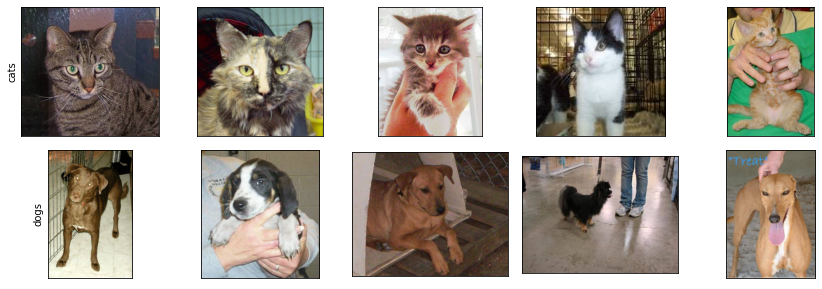

In [5]:
plt.figure(figsize=(12,12))
i=0
for c in os.listdir(TRAIN_DIR):  
    path = os.path.join(TRAIN_DIR,c)
    for img in os.listdir(path):
        img_array = cv2.cvtColor(cv2.imread(os.path.join(path,img)), cv2.COLOR_BGR2RGB) 
        plt.subplot(6,5,i+1)
        plt.imshow(img_array)
        if i%5 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%5 == 0:
            break

plt.tight_layout()        
plt.show() 

In [6]:
train_gen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=30,
    # randomly shift images horizontally
    width_shift_range=0.2,
    # randomly shift images vertically
    height_shift_range=0.2,
    # set range for random shear
    shear_range=0.2,
    # set range for random zoom
    zoom_range=0.3,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation 
    # (strictly between 0 and 1)
    validation_split=0.0,
    # datatype
    dtype=tf.float32,
)

test_gen = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.resnet50.preprocess_input, 
    dtype=tf.float32
)

In [7]:
train_batch = train_gen.flow_from_directory(
    directory = TRAIN_DIR,
    target_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    seed = SEED
)

Found 8005 images belonging to 2 classes.


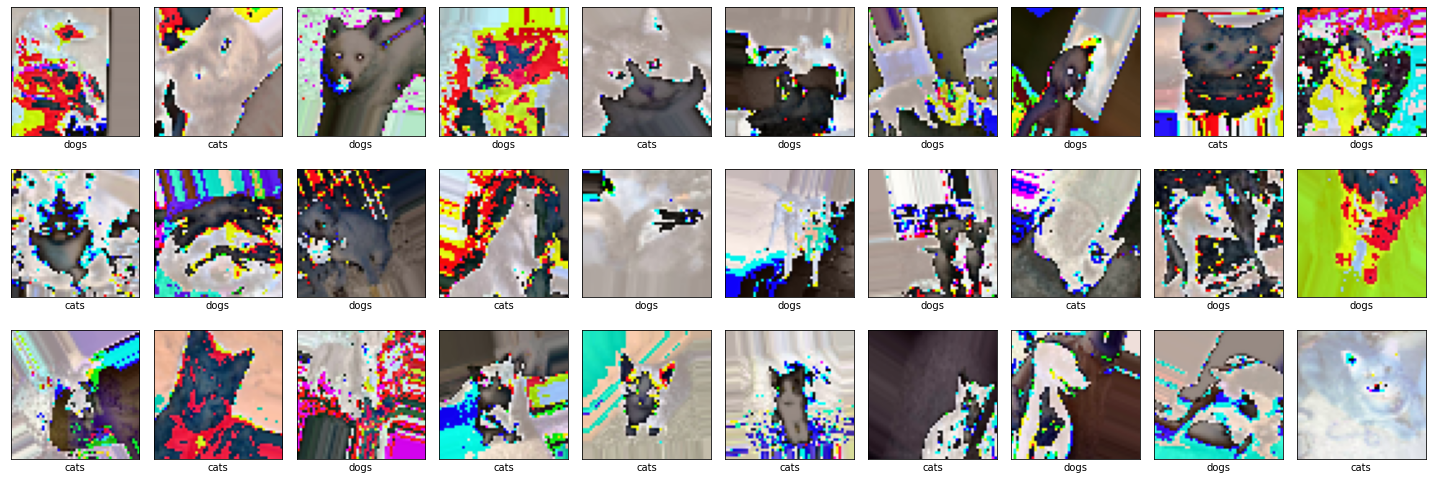

In [8]:
imgs, labels = next(train_batch)
i = 0
plt.figure(figsize=(20,7))
for img, label in zip(imgs, labels):
    plt.subplot(3,10,i+1)
    plt.imshow(img.astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_names[label.astype('int32')])
    i+=1
    if i == 30:
        break
plt.tight_layout()
plt.show()

In [9]:
valid_batch = train_gen.flow_from_directory(
    directory = TRAIN_DIR,
    target_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    seed = SEED
)

Found 8005 images belonging to 2 classes.


In [10]:
test_batch = test_gen.flow_from_directory(
    directory = TEST_DIR,
    target_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = None,
    seed = SEED
)

Found 2023 images belonging to 2 classes.


In [11]:
def identity_block(X, filters):
    f1, f2, f3,f4,f5 = filters
    X_copy = X
    
    # 1st Layer
    X = layers.Conv2D(filters=f1, kernel_size=(1,1), strides=(1,1), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X)
    
    # 2nd Layer
    X = layers.Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), padding='same')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X) 
    
    # 3rd Layer
    X = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=(1,1), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X) 
    # 4th Layer
    X = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=(1,1), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('softmax')(X) 
    
    # 5th Layer
    X = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=(1,1), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('sofmax')(X) 
    
    
    # Add the Skip COnnection
    X = layers.Add()([X, X_copy])
    X = layers.Activation('relu')(X)
    
    return X

In [12]:
def conv_blocks(X, filters, s=2):
    f1, f2, f3 = filters
    X_copy = X
    
    # 1st Layer
    X = layers.Conv2D(filters=f1, kernel_size=(1,1), strides=(s,s), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X)
    
    # 2nd Layer
    X = layers.Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), padding='same')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X) 
    
    # 3rd Layer
    X = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=(1,1), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    
    ### match the dimension
    X_copy = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=(s,s), padding='valid')(X_copy)
    X_copy = layers.BatchNormalization(axis=3)(X_copy)
    
    # Add the Skip COnnection
    X = layers.Add()([X, X_copy])
    X = layers.Activation('relu')(X)
    
    return X

In [13]:
def ResNet50():
    X_input = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    X = layers.ZeroPadding2D((3,3))(X_input)
    
    # Satge Conv1
    X = layers.Conv2D(64, (7,7), strides=(2,2))(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X) 
    X = layers.MaxPooling2D((3,3), strides=(2,2))(X)
    
    # stage Conv2_x
    X = conv_blocks(X, filters=[64,64,256], s=1)
    X = identity_block(X, filters=[64,64,256])
    X = identity_block(X, filters=[64,64,256])
    
    # stage Conv3_x
    X = conv_blocks(X, filters=[128,128,512], s=2)
    X = identity_block(X, filters=[128,128,512])
    X = identity_block(X, filters=[128,128,512])
    X = identity_block(X, filters=[128,128,512])
    
    # stage Conv4_x
    X = conv_blocks(X, filters=[256,256,1024], s=2)
    X = identity_block(X, filters=[256,256,1024])
    X = identity_block(X, filters=[256,256,1024])
    X = identity_block(X, filters=[256,256,1024])
    X = identity_block(X, filters=[256,256,1024])
    X = identity_block(X, filters=[256,256,1024])
    
    # stage Conv5_x
    X = conv_blocks(X, filters=[512,512,2048], s=2)
    X = identity_block(X, filters=[512,512,2048])
    X = identity_block(X, filters=[512,512,2048])
    
    
    X = layers.AveragePooling2D((2,2))(X)
    X = layers.Flatten()(X)
    X = layers.Dense(10, activation='softmax', kernel_initializer='he_normal')(X)
    
    model = keras.Model(inputs=X_input, outputs=X, name='ResNet50')
    
    return model

In [14]:
model = ResNet50()
model.summary()

ValueError: not enough values to unpack (expected 5, got 3)

In [ ]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 40:
        lr *= 0.5e-3
    elif epoch > 30:
        lr *= 1e-3
    elif epoch > 20:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(lr=lr_schedule(0)), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
h = model.fit(train_batch, 
              epochs=50,
              steps_per_epoch = TRAIN_EXAMPLES // BATCH_SIZE,
              validation_data = valid_batch,
              validation_steps = 8005 // BATCH_SIZE,
              callbacks=lr_scheduler,
              verbose=2
             )

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],  label='train accuracy')
plt.plot(h.history['val_accuracy'],  label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'],  label='train loss')
plt.plot(h.history['val_loss'],  label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.ylim([0,1])
plt.legend(loc='upper right')

plt.show()